# Exploring Keras

## Imports

In [1]:
import itertools
import functools
from collections import deque

import numpy as np
import matplotlib.animation
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG, HTML, display

Using TensorFlow backend.


## Utilities

In [2]:
int_colors = {
    1: (.2, 1, .2),
    0: (1, .2, .2)
}

def int_to_color(alpha=1):
    return functools.partial(int_to_color_alpha, alpha=alpha)

def int_to_color_alpha(v, alpha):
    return int_colors[v] + (alpha,)

## Define the data sets

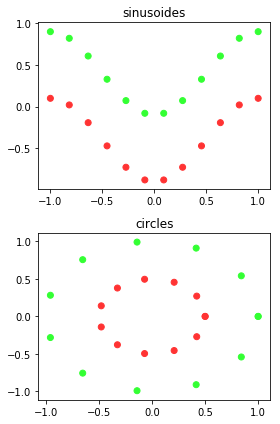

In [3]:
n = 2 * 12

# Sinusoides
data_sinusoides = np.zeros((n, 3))
x_sinusoides = np.linspace(-1, 1, n // 2)
data_sinusoides[:, 0] = np.concatenate([x_sinusoides, x_sinusoides])
data_sinusoides[:, 1] = np.concatenate([.4 - np.cos(np.pi * x_sinusoides) / 2,
                                        -.4 - np.cos(np.pi * x_sinusoides) / 2])
data_sinusoides[:, 2] = np.concatenate([np.ones(n//2), np.zeros(n//2)])

# Circles
theta = np.linspace(0, 2 * np.pi, n // 2)
data_circles = np.zeros((n, 3))
data_circles[:, 0] = np.concatenate([np.cos(theta), 1/2 * np.cos(theta)])
data_circles[:, 1] = np.concatenate([np.sin(theta), 1/2 * np.sin(theta)])
data_circles[:, 2] = np.concatenate([np.ones(n//2), np.zeros(n//2)])

# Plot our data sets
datasets = {
    'sinusoides': data_sinusoides,
    'circles': data_circles,
}

fig, axes = plt.subplots(len(datasets), 1, figsize=(4, 3 * len(datasets)))
for i, (name, data) in enumerate(datasets.items()):
    axes[i].scatter(data[:, 0], data[:, 1], color=list(map(int_to_color(), data[:, 2])))
    axes[i].set_title(name)
fig.tight_layout()

## Define the model evolution plotting functions

In [4]:
def make_model():
    model = Sequential()
    model.add(Dense(2, input_dim=2, activation='tanh',
                    #kernel_initializer='identity',
                    #bias_initializer='zeros')
                   ))
    model.add(Dense(2, activation='softmax'))

    #sgd = keras.optimizers.SGD(lr=0.01, momentum=0.1, decay=0.001)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    print('New model with the following architecture:')
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))
    return model

In [5]:
def build_train_animation(data):
    model = make_model()
    
    # Create the training data
    T = np.zeros((n, 4))
    T[:, :2] = data[:, :2]
    T[:, 2] = 1 - data[:, 2]
    T[:, 3] = data[:, 2]

    # A few parameters
    grid_density = 50
    stop_patience = 3
    dloss_tol = 1e-5

    # Prepare the grid, loss tracking, and other utils
    grid = np.array(list(itertools.product(np.linspace(data[:,0].min(), data[:,0].max(), grid_density),
                                           np.linspace(data[:,1].min(), data[:,1].max(), grid_density))))
    losses = list(range(stop_patience + 1, 0, -1))
    
    def dlosses(losses):
        last_losses = np.array(losses[-(stop_patience + 1):])
        return np.abs(last_losses[1:] - last_losses[:-1])

    def dlosses_text(losses):
        return r'$\Delta losses =$ ' + ', '.join(['{:.2e}'.format(dl) for dl in dlosses(losses)])

    def layer_transform(layer, data):
        return layer\
            .activation(data[:, :2].dot(layer.get_weights()[0]) + layer.get_weights()[1])\
            .eval(session=keras.backend.get_session())

    # Prepare the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    prediction_collection = ax1.scatter(grid[:, 0], grid[:, 1], color=(.1, .1, .1, .1))
    prediction_dlosses = ax1.text(.5, 1, dlosses_text(losses),
                                  ha='center', va='top', transform=ax1.transAxes,
                                  bbox=dict(facecolor='white', alpha=0.8))
    tr_grid = layer_transform(model.layers[0], grid)
    tr_data = layer_transform(model.layers[0], data)
    tr_prediction_collection = ax2.scatter(tr_grid[:, 0], tr_grid[:, 1],
                                           color=(.1, .1, .1, .1))
    tr_data_collection = ax2.scatter(tr_data[:, 0], tr_data[:, 1],
                                     color=list(map(int_to_color(), data[:, 2])))

    # Create the animation
    def init_plot():
        ax1.scatter(data[:, 0], data[:, 1], color=list(map(int_to_color(), data[:, 2])))
        ax2.set_xlim(-1, 1)
        ax2.set_ylim(-1, 1)
        return prediction_collection, prediction_dlosses, tr_data_collection, tr_prediction_collection

    def update_predictions(frame):
        history = model.fit(T[:,:2], T[:, 2:4], epochs=10, batch_size=n, verbose=0)
        losses.append(history.history['loss'][-1])

        grid_predictions = model.predict(grid) / 2
        colors = list(map(int_to_color(.1),
                          1 + np.floor(grid_predictions[:, 1] - grid_predictions[:, 0]).astype(np.int)))

        prediction_collection.set_color(colors)
        prediction_dlosses.set_text(dlosses_text(losses))

        tr_grid = layer_transform(model.layers[0], grid)
        tr_prediction_collection.set_offsets(tr_grid)
        tr_prediction_collection.set_color(colors)
        tr_data = layer_transform(model.layers[0], data)
        tr_data_collection.set_offsets(tr_data)

        return prediction_collection, prediction_dlosses, tr_data_collection, tr_prediction_collection

    def model_frames():
        counter = 0
        while True:
            if np.all(dlosses(losses) < dloss_tol):
                return
            else:
                yield counter
                counter += 1

    return matplotlib.animation.FuncAnimation(fig, update_predictions, blit=True,
                                              init_func=init_plot,
                                              interval=10,
                                              save_count=1000,
                                              frames=model_frames(),
                                              repeat=False)

## Generate the videos for each dataset


Dataset 'sinusoides'
New model with the following architecture:


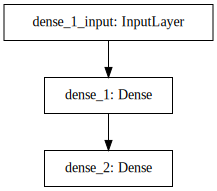


Dataset 'circles'
New model with the following architecture:


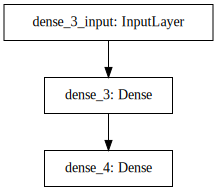

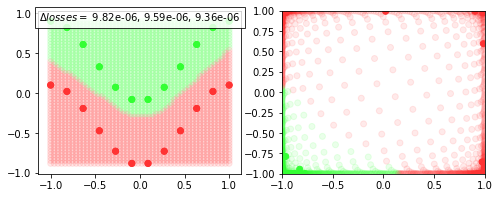

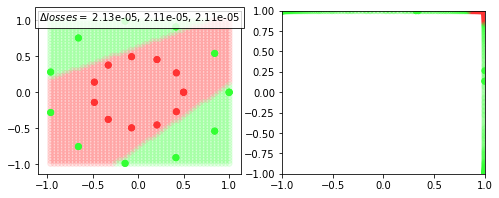

In [6]:
for name, data in datasets.items():
    print()
    print("Dataset '{}'".format(name))
    video = build_train_animation(data).to_html5_video()
    display(HTML(video))